## Practica 1

### Setup

In [1]:
# Librerias generales
library(fda)
# library(tidyverse)

# Dispositivos graficos
library(repr)
options(repr.plot.width=12, repr.plot.height=7)
ROWS <- 1
COLS <- 2

Loading required package: Matrix


Attaching package: ‘fda’


The following object is masked from ‘package:graphics’:

    matplot




### Ejercicio 1.3 (1.5 Kokoszka)

En R, las funciones son objetos de primera clase. En particular, esto quiere decir que una funcion puede devolver _otra_ funcion. Para nuestros operadores, que van de espacios de Hilbert a espacios de Hilbert, esta habilidad del lenguaje resulta muy conveniente.

In [2]:
timesX <- function(x) {
    timesX_ <- function(y) {
        return(y * x)
    }
    return(timesX_)
}

In [3]:
times3 <- timesX(3)

In [4]:
times3(5)

[1] 15

In [5]:
stopifnot(
    3 * 4 == timesX(3)(4),
    3 * 4 == timesX(3)(timesX(4)(1))
)

Las funciones de interes por ahora son el nucleo de covarianza de Matern $\gamma_\nu(s, t)$, y la funcion auxiliar $C$.

In [6]:
make_CE <- function(nu, sigma) {
    if (nu <= 0)
        stop("Nu debe ser un escalar positivo")
    if (length(sigma) > 1 | sigma < 0)
        stop("Sigma debe ser un escalar no negativo")
    CE <- function(u) {
#         print(c(u, nu, sigma^2, 2^(1-nu), u^nu, besselK(u, nu), gamma(nu)))
        ifelse(
            u == 0,
            1,
            sigma^2 * 2^(1-nu) * u^nu * besselK(u, nu) / gamma(nu)
        )
    }
    return(CE)
}

make_kern <- function(nu, ro, sigma) {
    CE <- make_CE(nu, sigma)
    kern <- function(t, s) {
        return(CE(sqrt(2 * nu) * abs(s - t) / ro))
    }
    return(kern)
}

In [7]:
rmvnorm <- function(mu, sigma, n=1) {
    p <- length(mu)
    L <- chol(sigma)
    # M %*% t(M)
    Z <- matrix(rnorm(p * n),p, n) # 2 rows, N/2 columns
    ret <- t(L) %*% Z + matrix(rep(mu, n), nrow=p)
    return(ret)
}

In [8]:
# Repaso de descomposicio nde Cholesky
# Genero una matriz simetrica al azar
M <- matrix(rnorm(9), ncol = 3)
S <- M %*% t(M)
D <- chol(S)

stopifnot(max(t(D) %*% D - S) < 1e-10)
t(D)

2.5161233,0.0000000,0.0000000
1.1633781,0.4320827,0.0000000
0.4435976,-1.0450848,0.1663127


In [9]:
# Estimador media
get_muhat <- function(X) {
    # X tiene N observaciones (columnas) p-variadas, y es de dimension p * n
    apply(X, ROWS, mean)
}
# Estimador covarianza
get_gammahat <- function(X, mu = NULL) {
    if (is.null(mu)) {
        muhat <- get_muhat(X)
    } else {
        muhat <- mu
    }
    N <- dim(X)[2]
#     print(N)
    Xcent <- X - matrix(rep(muhat, N), ncol=N)
#     print(Xcent)
    ret <- (1 / N) * Xcent %*% t(Xcent)
#     print(ret)
    ret
} 

In [10]:
SEMILLA <- 1234
T <- 50  # tamaño de la grilla de evaluación
LIMITES <- c(0, 1)
GRILLA <- seq(LIMITES[1], LIMITES[2], length.out = T) 
N <- 100
MU <- vector("numeric", T)  # funcion de media
RO <- 1
SIGMA <- 1

Genero, para cada $\nu$,
- la funcion nucleo de covarianza `kern`,
- una muestra de `N` procesos iid,
- la funcion de media muestral `muhat`, y
- las matrices de covarianza verdadera (`matcov`) y estimada (`gammahat`) para una grilla esquiespaciada de `T` puntos.

Con estos datos, podemos realizar todos los graficos deseados.

In [11]:
nus <- c(1, 4, 8) / 2
resultados <- list()
for (i in seq_along(nus)) {
    nu <- nus[i]
    print(nu)
    kern <- make_kern(nu, RO, SIGMA)
    matcov <- outer(GRILLA, GRILLA, kern)
    set.seed(SEMILLA)
    X <- rmvnorm(MU, matcov, N)
    muhat <- get_muhat(X)
    gammahat <- get_gammahat(X)

    resultados[[i]] <- list(
        kern=kern,
        nu=nu,
        matcov=matcov,
        X=X,
        muhat=muhat, 
        gammahat=gammahat
    )
}

[1] 0.5
[1] 2
[1] 4


Dado un elemento de la lista `resultados` recién generada, la siguiente función genera distintos gráficos de interés.

In [12]:
plots <- function(r) {
    print(r$nu)
    partial <- function(t) { r$kern(t, 0.5) }
    plot.new()
    # Covarianza de distintos puntos con t=0,
    curve(partial, LIMITES[1], LIMITES[2])
    # Plots de contorno y perspectiva para la matriz de covarianza real y estimada
    contour(r$matcov)
    contour(r$gammahat)
    persp(r$matcov, theta=30)
    persp(r$gammahat, theta=30)
    filled.contour(r$matcov)
    filled.contour(r$gammahat)
    # Diferencia entre la matriz de covarianza real y estimada
    filled.contour(r$matcov - r$gammahat)
    print(mean((r$matcov - r$gammahat)^2))
    # 5 trayectorias de procesos
    plot(GRILLA, r$X[,1], 'l', ylim=c(-4, 4))
    for (j in seq.int(5)) {
        lines(GRILLA, r$X[,j], 'l')
    }
}

[1] 0.5


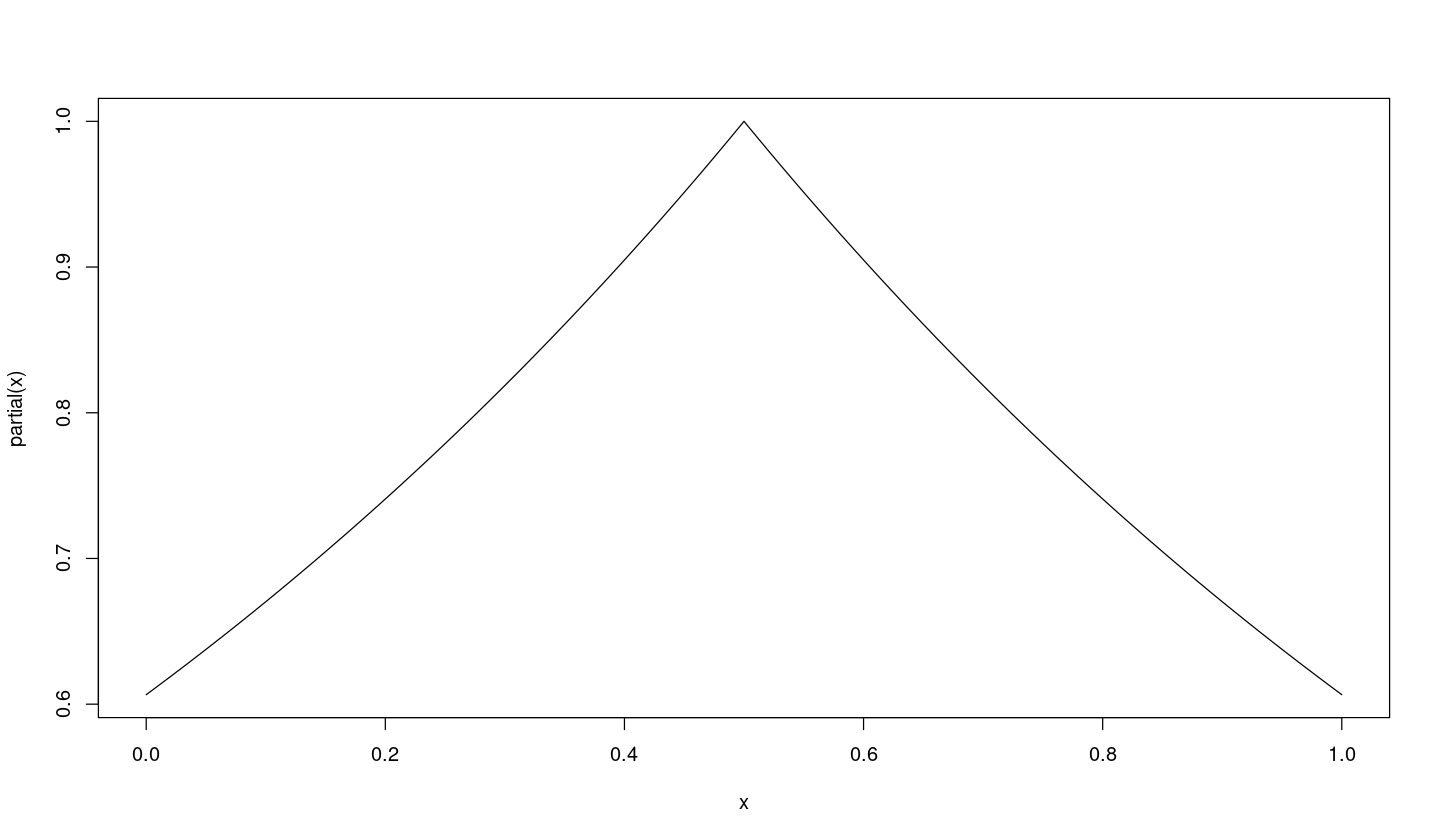

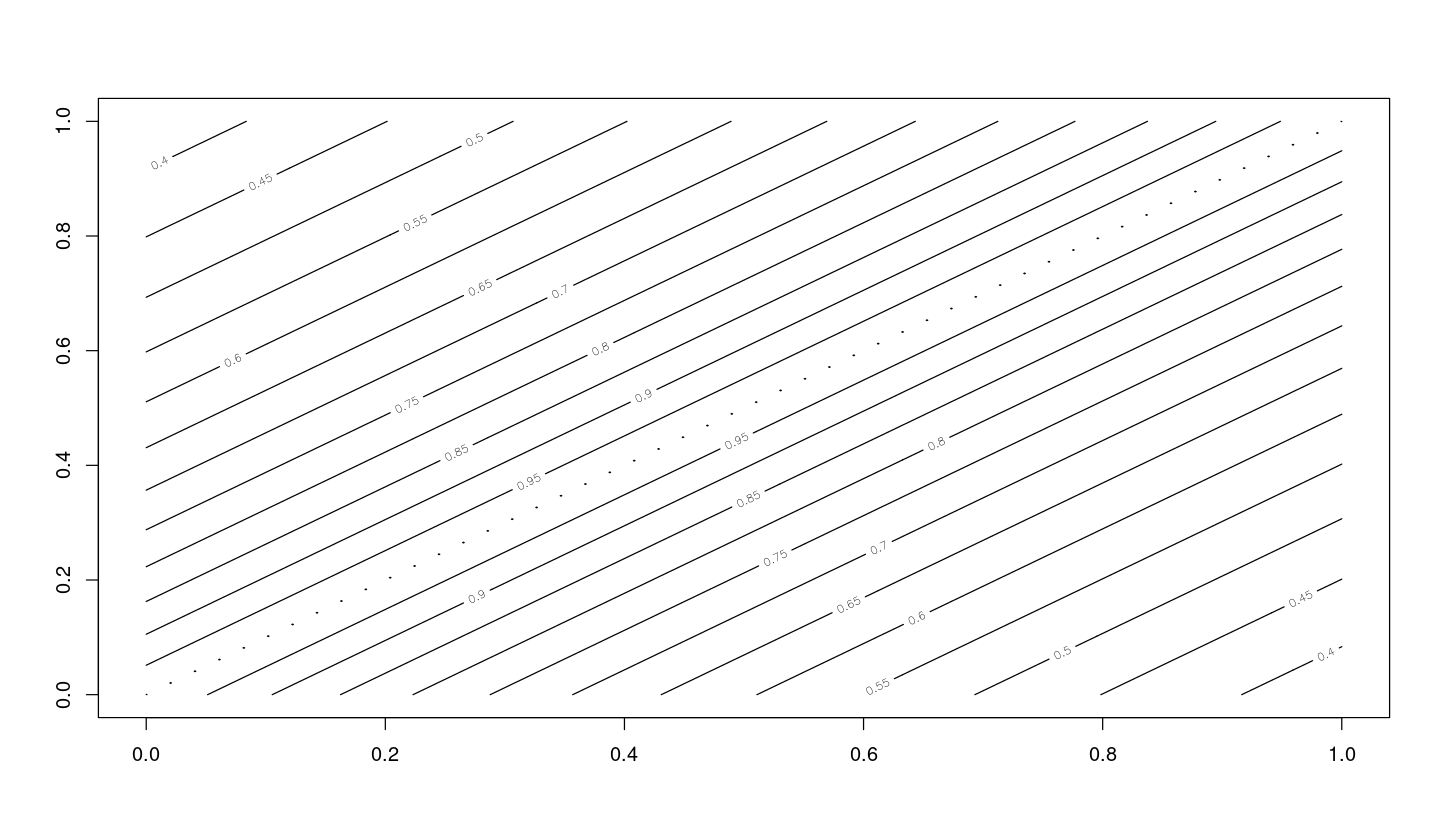

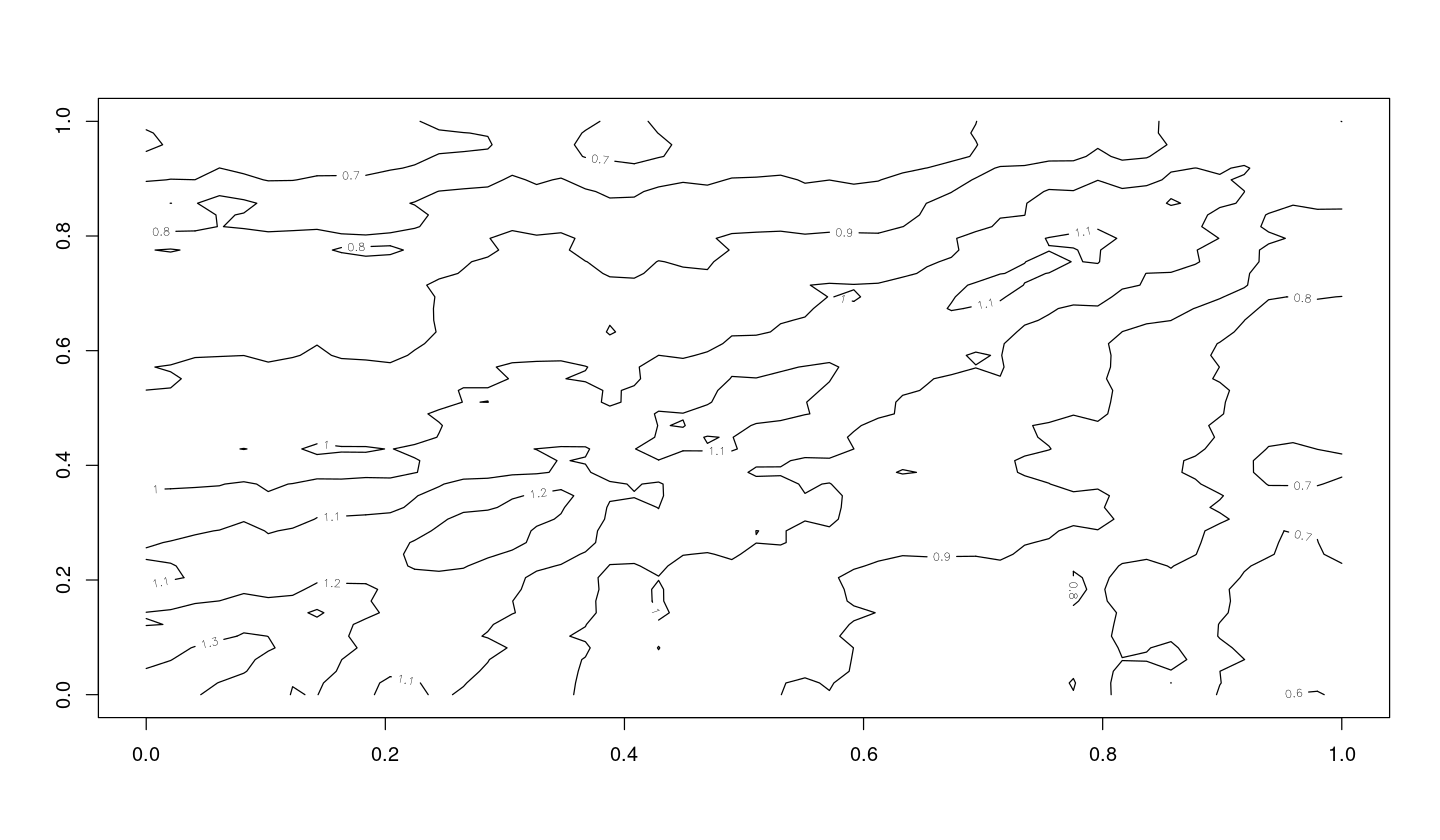

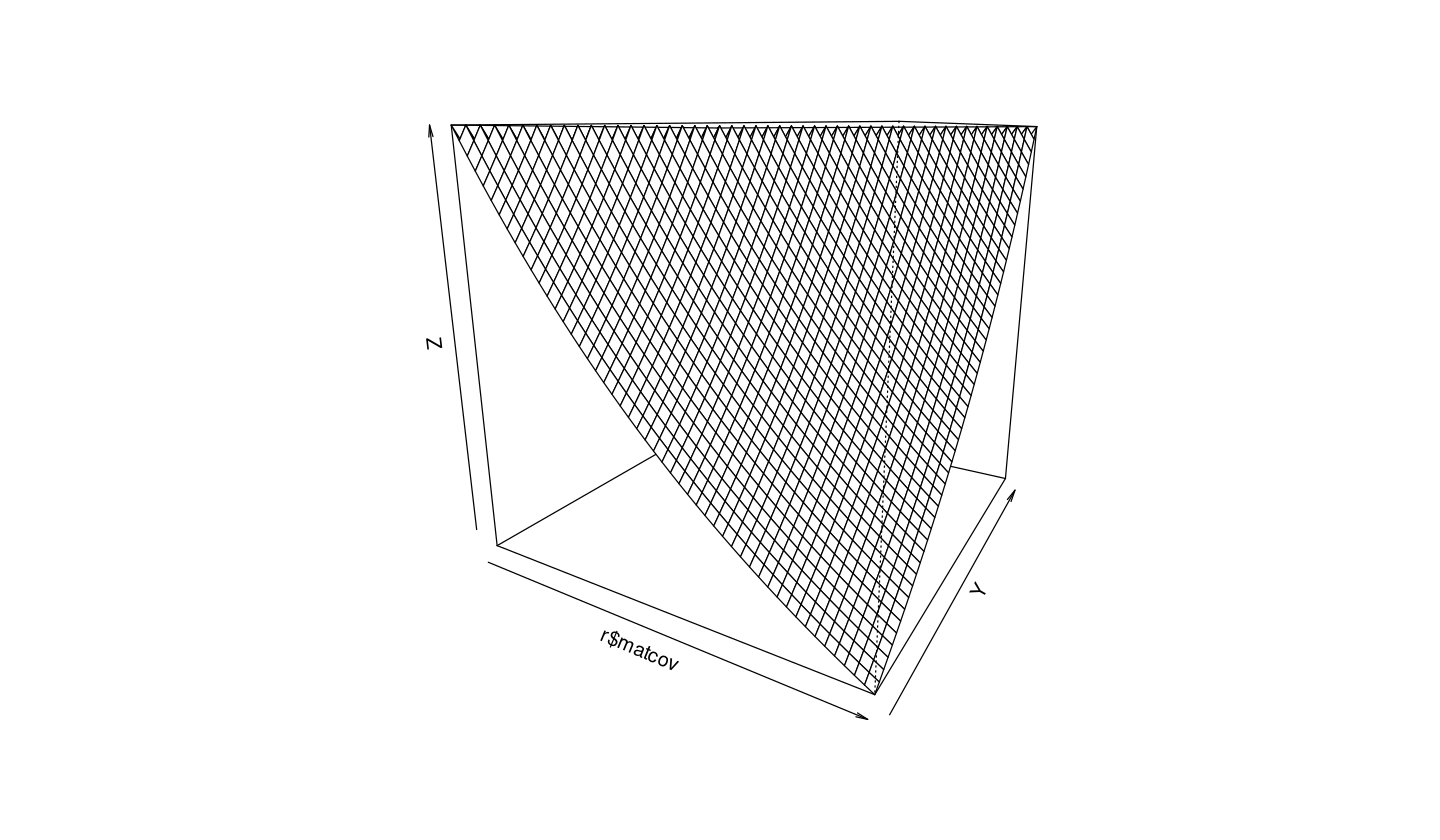

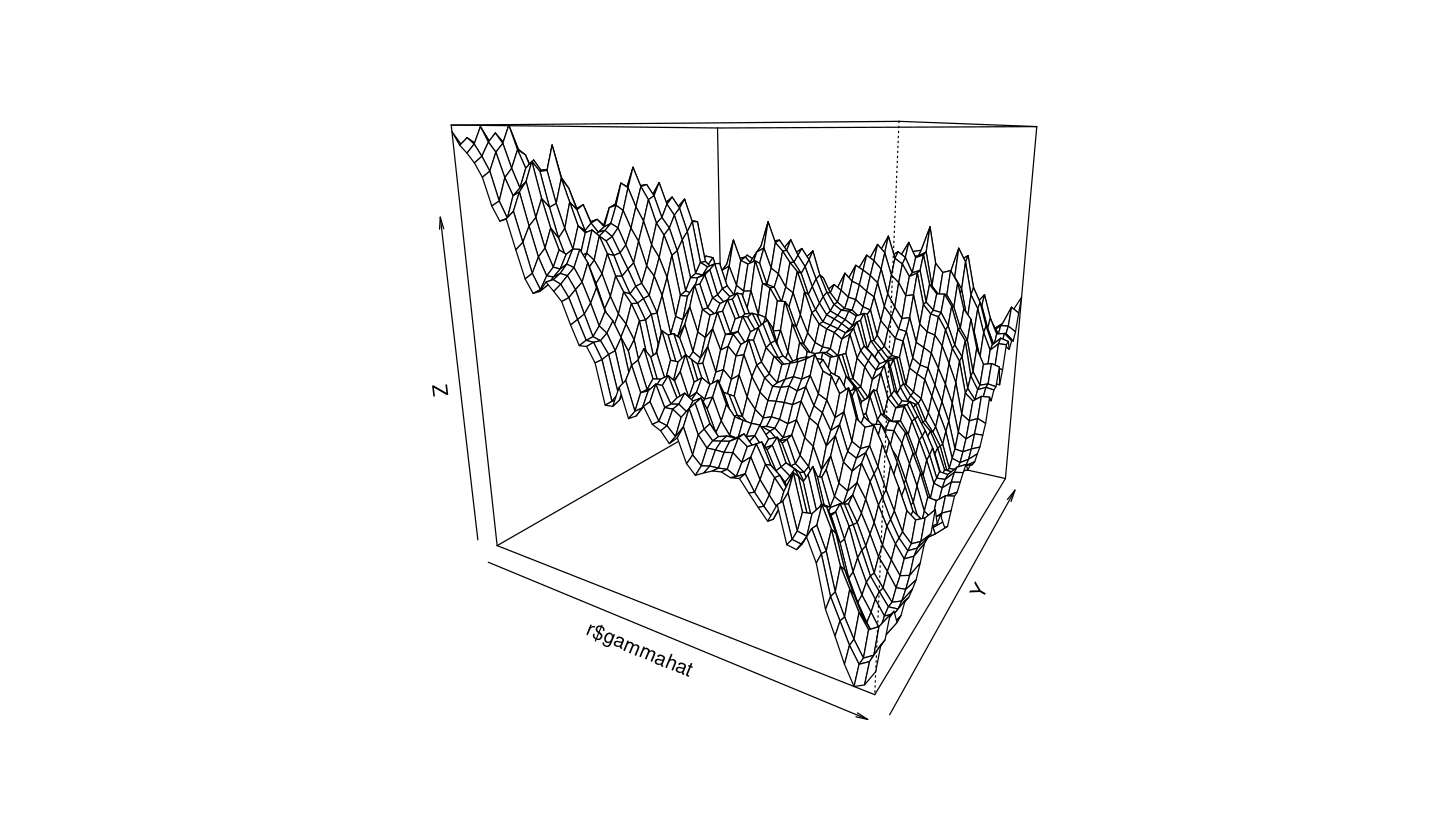

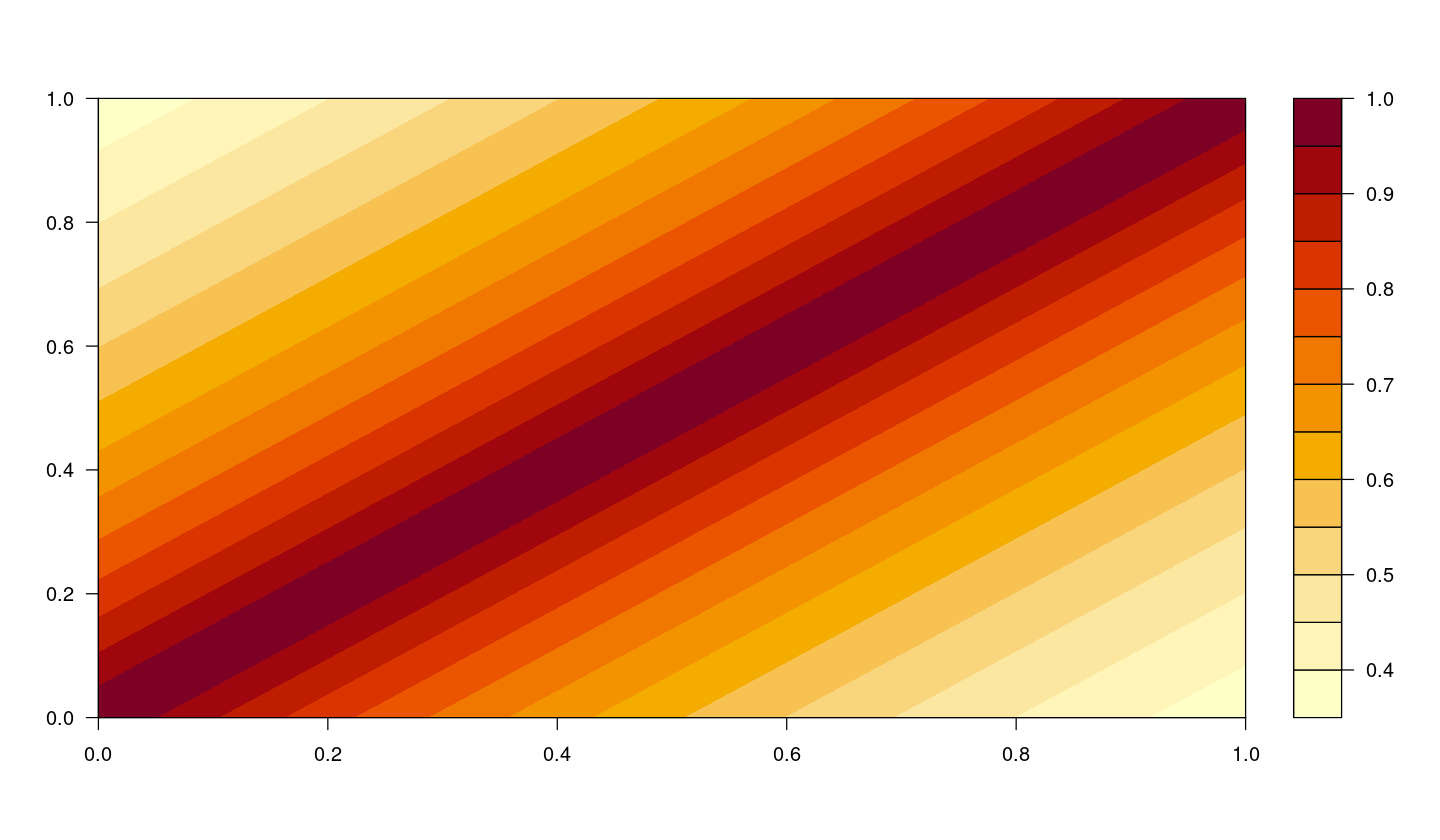

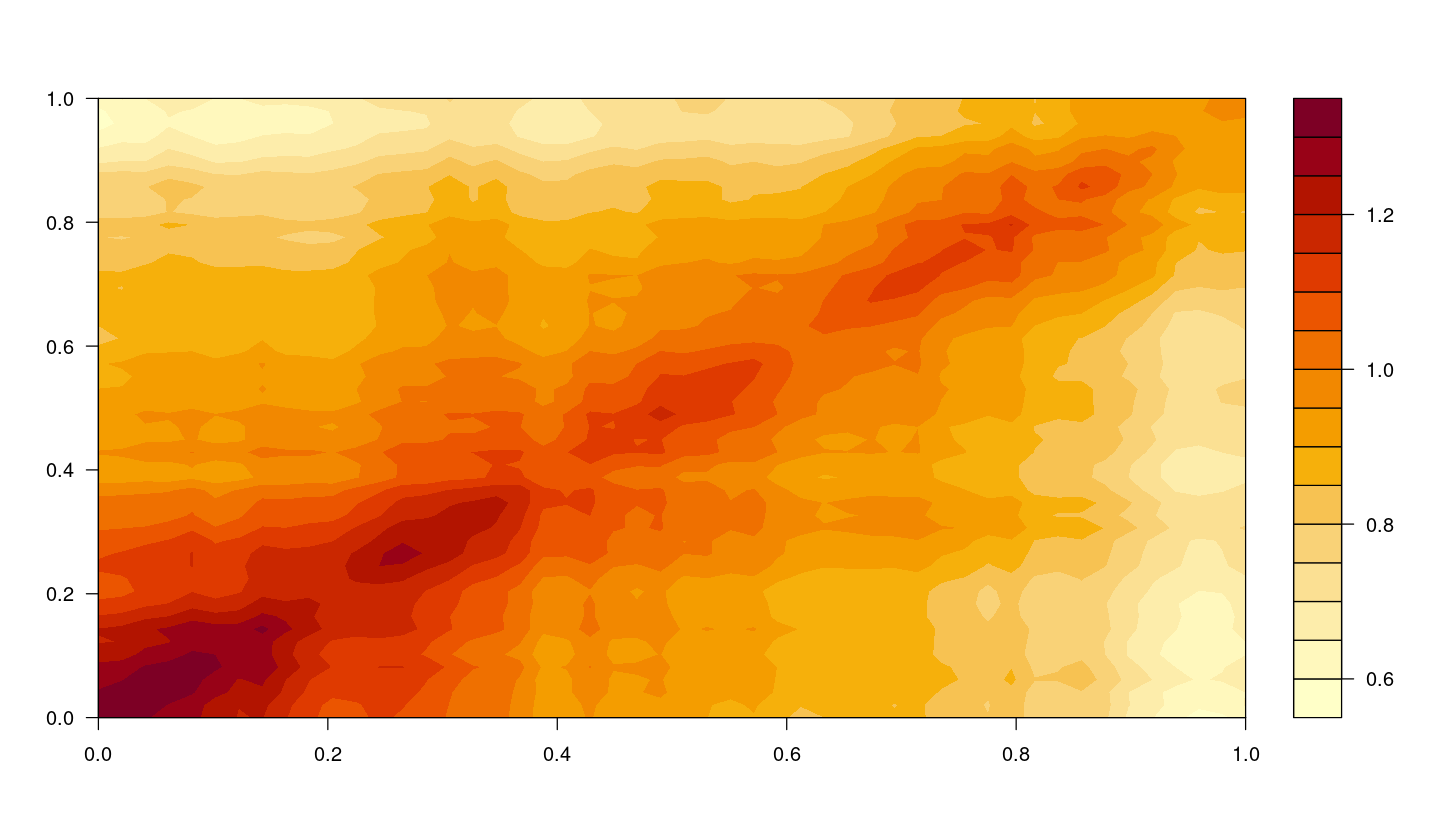

[1] 0.04655323


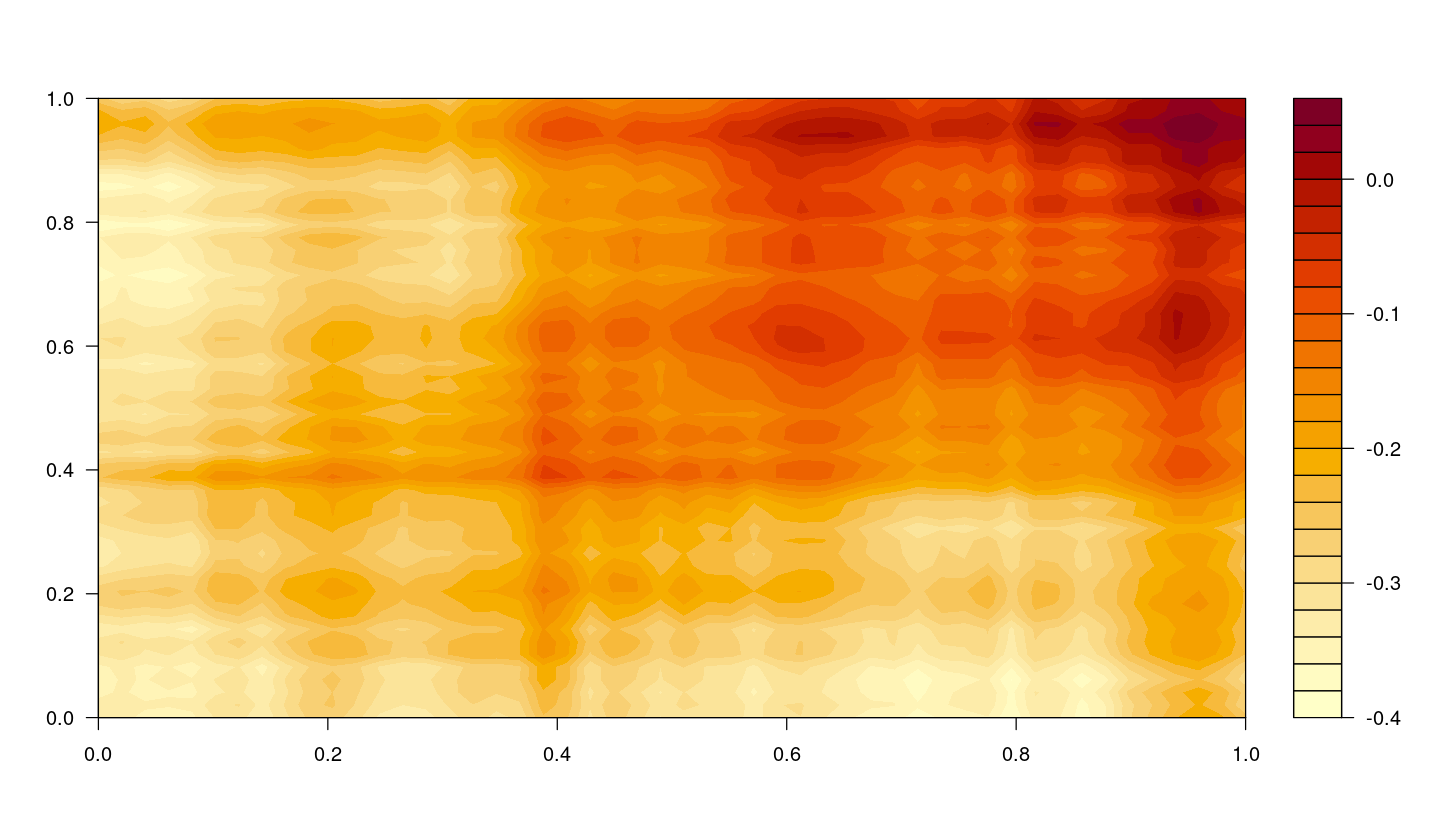

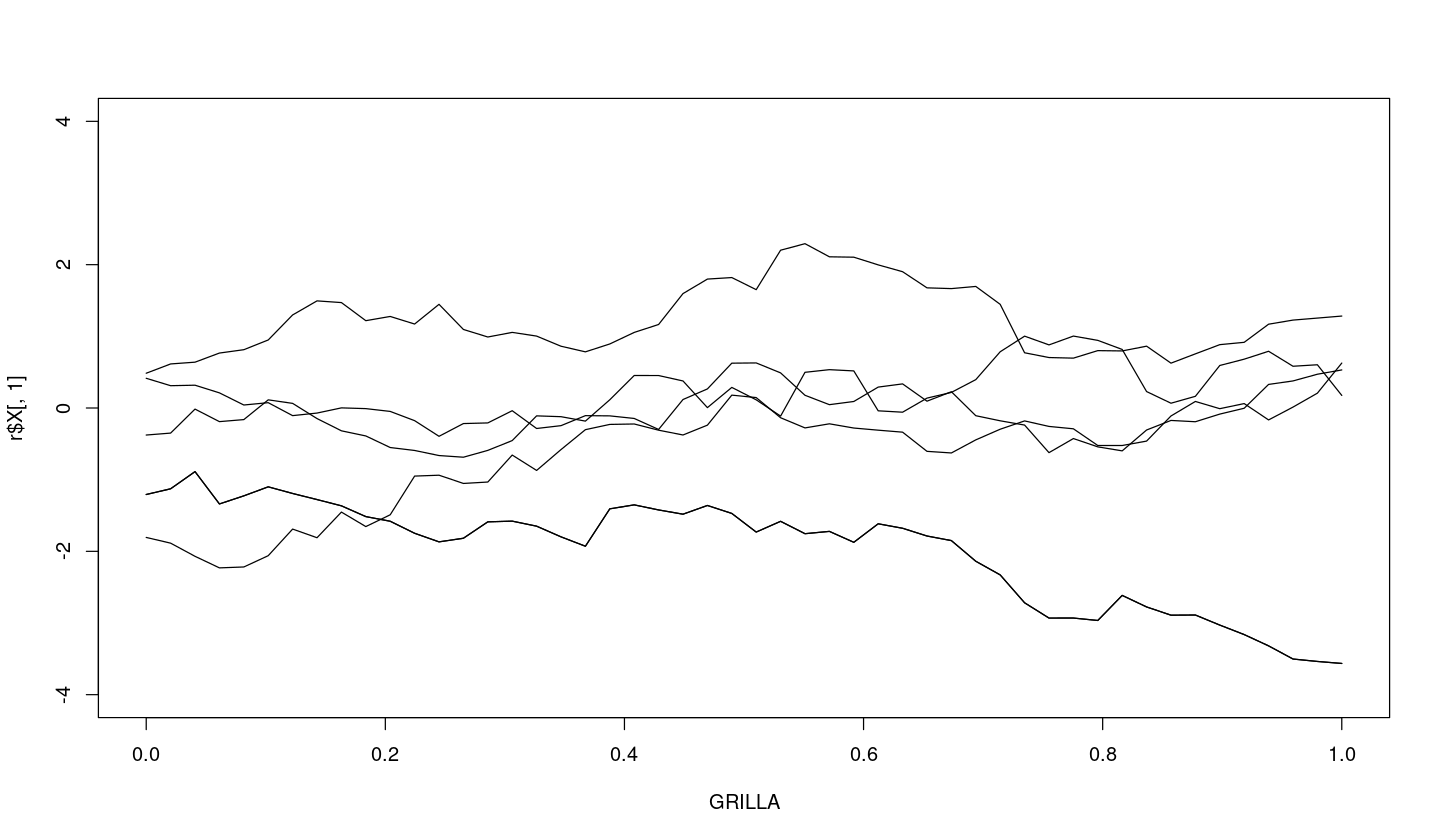

In [13]:
plots(resultados[[1]])

In [14]:
N_BASES <- 40 # debe ser estrictamente menor a T! por que? Probar con 50
base.bsplines <- create.bspline.basis(rangeval = LIMITES, nbasis = N_BASES, norder = 4)

In [32]:
J <- 1  # indice de `resultados` a utilizar
resultado <- resultados[[J]]
X <- resultado$X
X.fd <- smooth.basis(GRILLA, X, base.bsplines)
matcov <- resultado$matcov
gammahat <- resultado$gammahat

### Componentes Principales

#### Componentes principales funcionales con `pca.fd`

[1] "done"

[1] 0.81216986 0.08477898 0.03564905 0.01922337

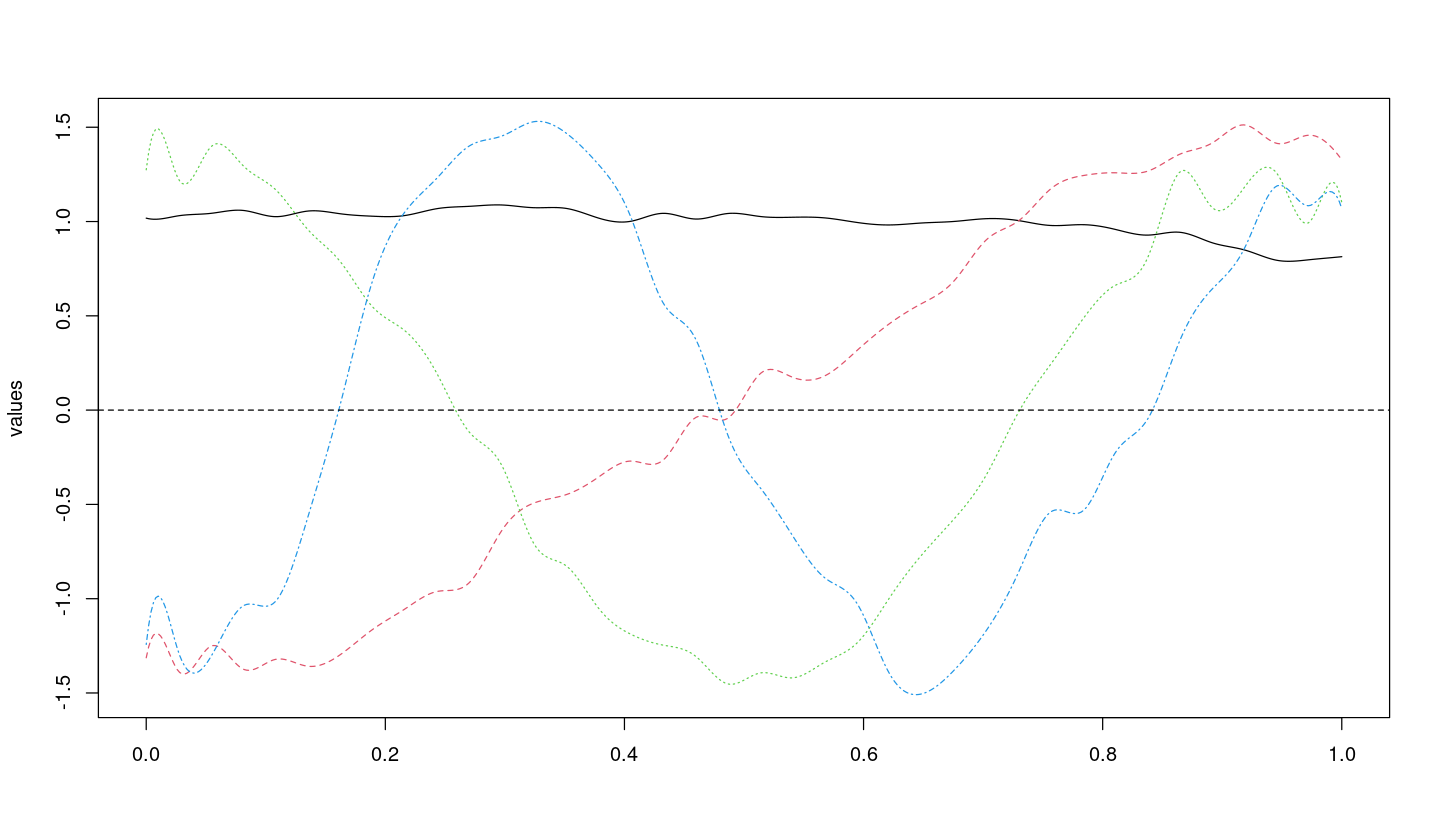

In [33]:
X.pca = pca.fd(X.fd$fd, nharm=4)
# plot(X.pca)

plot(X.pca$harmonics, lwd=3)
X.pca$varprop

#### Componentes principales "a mano" a partir de la muestra simulada

[1] 0.80855428 0.08615983 0.03567327 0.01941428

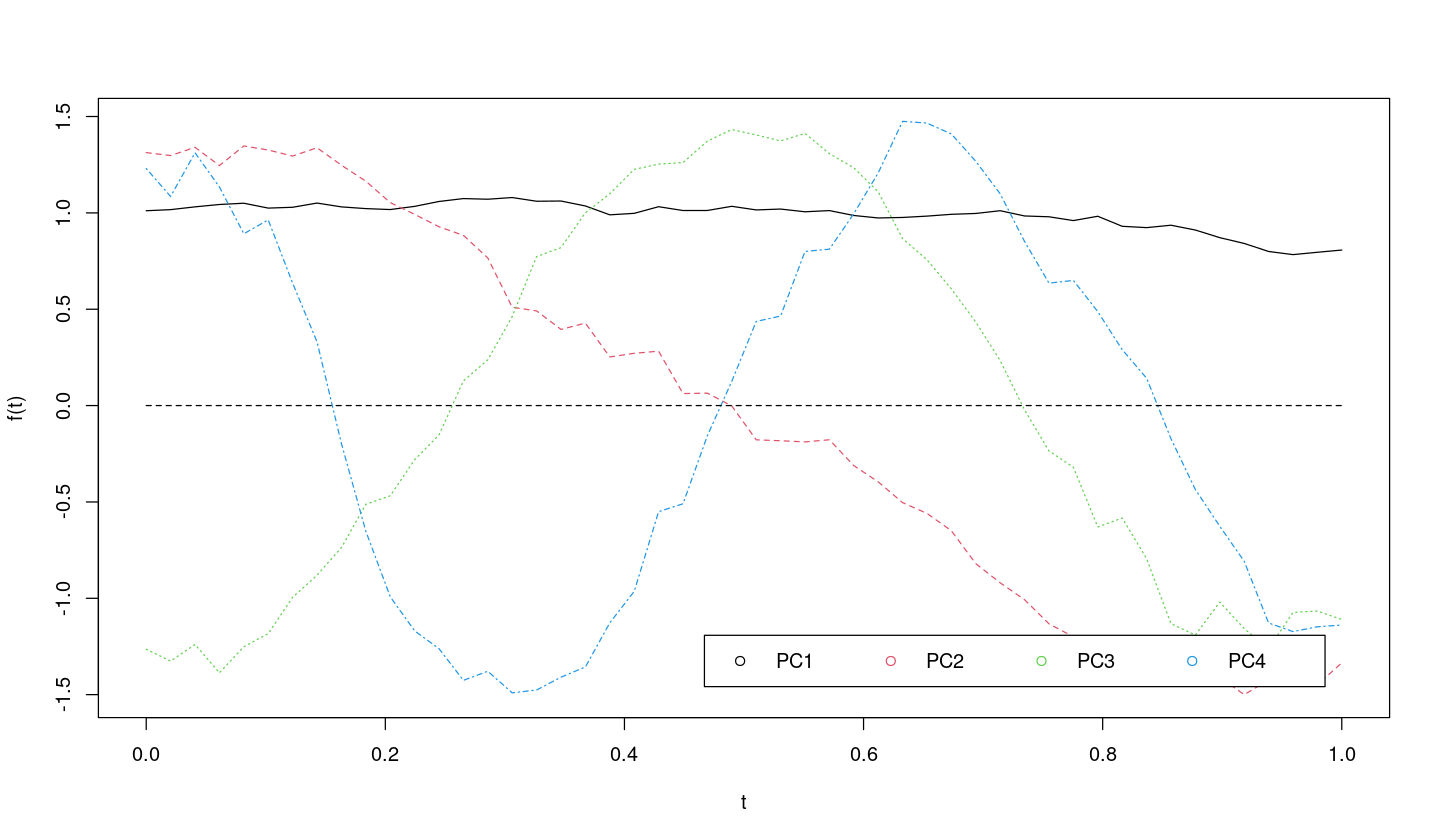

In [34]:
pcaX <- prcomp(t(X))
m1 <- pcaX$rotation[,1:4] * sqrt(T - 1)  # Para que tengan norma en L2 == 1 (cuadrado-integren a 1)
pcaX$sdev[1:4]**2 / sum(pcaX$sdev**2)
matplot(GRILLA, m1, type='l', xlab='t', ylab='f(t)', col=1:5)
lines(GRILLA, rep(0, T), lty=2)
legend('bottomright', inset=.05, legend=colnames(m1), 
                            pch=1, horiz=TRUE, col=1:5)


#### Componenes principales de la matriz de covarianza $\Gamma$ a partir de sus autoelementos

In [35]:
eig <- eigen(matcov)

In [36]:
stopifnot(max(matcov %*% eig$vectors[,1] - eig$values[1]  * eig$vectors[,1]) < 1e-10)

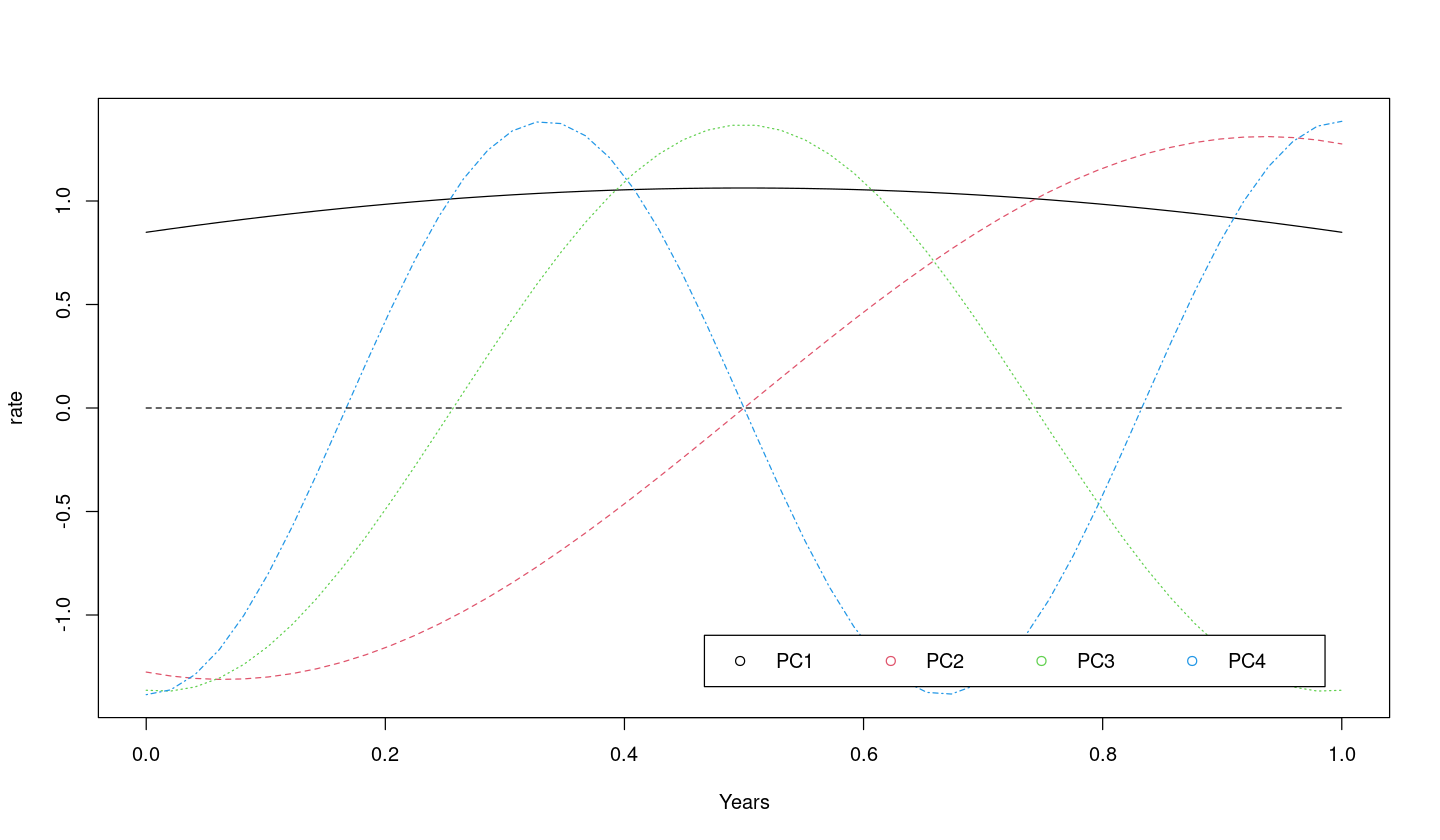

In [37]:
m1 <- eig$vectors[,1:4] * sqrt(T - 1) * matrix(rep(c(-1, 1 , 1, 1), T), byrow=T, nrow=T) 
# for (i in c(1, 2, 3)) {
#     m1[,i] <- -m1[,i]  #Cambio de signo de ciertas autofunciones
# }
matplot(GRILLA, m1, type='l', xlab='Years', ylab='rate', col=1:5)
lines(GRILLA, rep(0, T), lty=2)
legend('bottomright', inset=.05, legend=c("PC1", "PC2", "PC3", "PC4"), 
                            pch=1, horiz=TRUE, col=1:5)

#### Componenes principales de la matriz de covarianza estimada $\hat\Gamma$ a partir de sus autoelementos

In [38]:
eig <- eigen(gammahat)

In [39]:
stopifnot(max(gammahat %*% eig$vectors[,1] - eig$values[1]  * eig$vectors[,1]) < 1e-10)

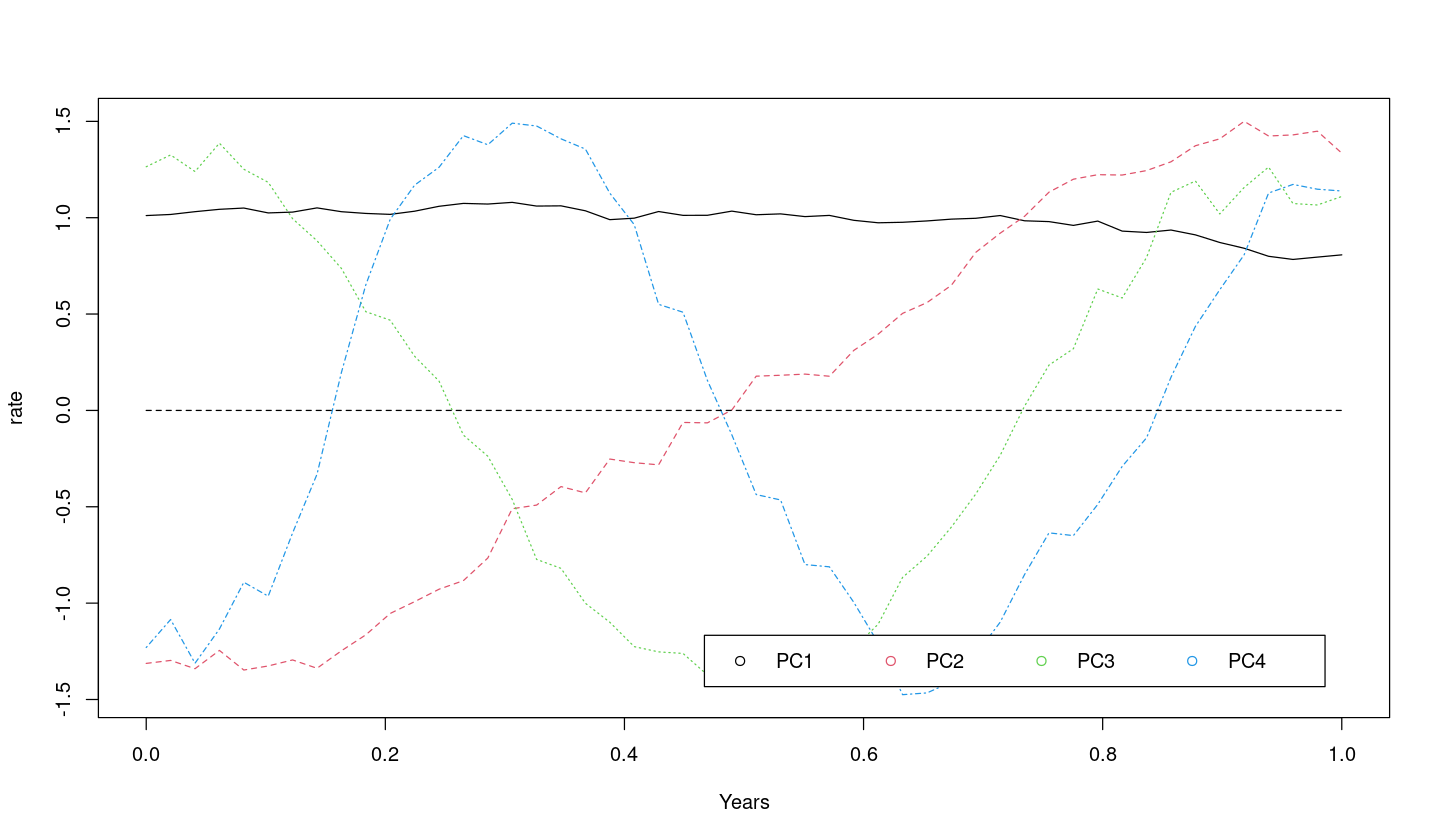

In [40]:
m1 <- eig$vectors[,1:4] * sqrt(T - 1) * matrix(rep(c(1, -1 , 1, 1), T), byrow=T, nrow=T) 
for (i in c(1, 2, 3)) {
    m1[,i] <- -m1[,i]  #Cambio de signo de ciertas autofunciones
}
matplot(GRILLA, m1, type='l', xlab='Years', ylab='rate', col=1:5)
lines(GRILLA, rep(0, T), lty=2)
legend('bottomright', inset=.05, legend=c("PC1", "PC2", "PC3", "PC4"), 
                            pch=1, horiz=TRUE, col=1:5)

### Derivadas Primeras

#### Usando `deriv.fd`

Ploteamos las derivadas de las primeras cinco observaciones juntas

[1] "done"

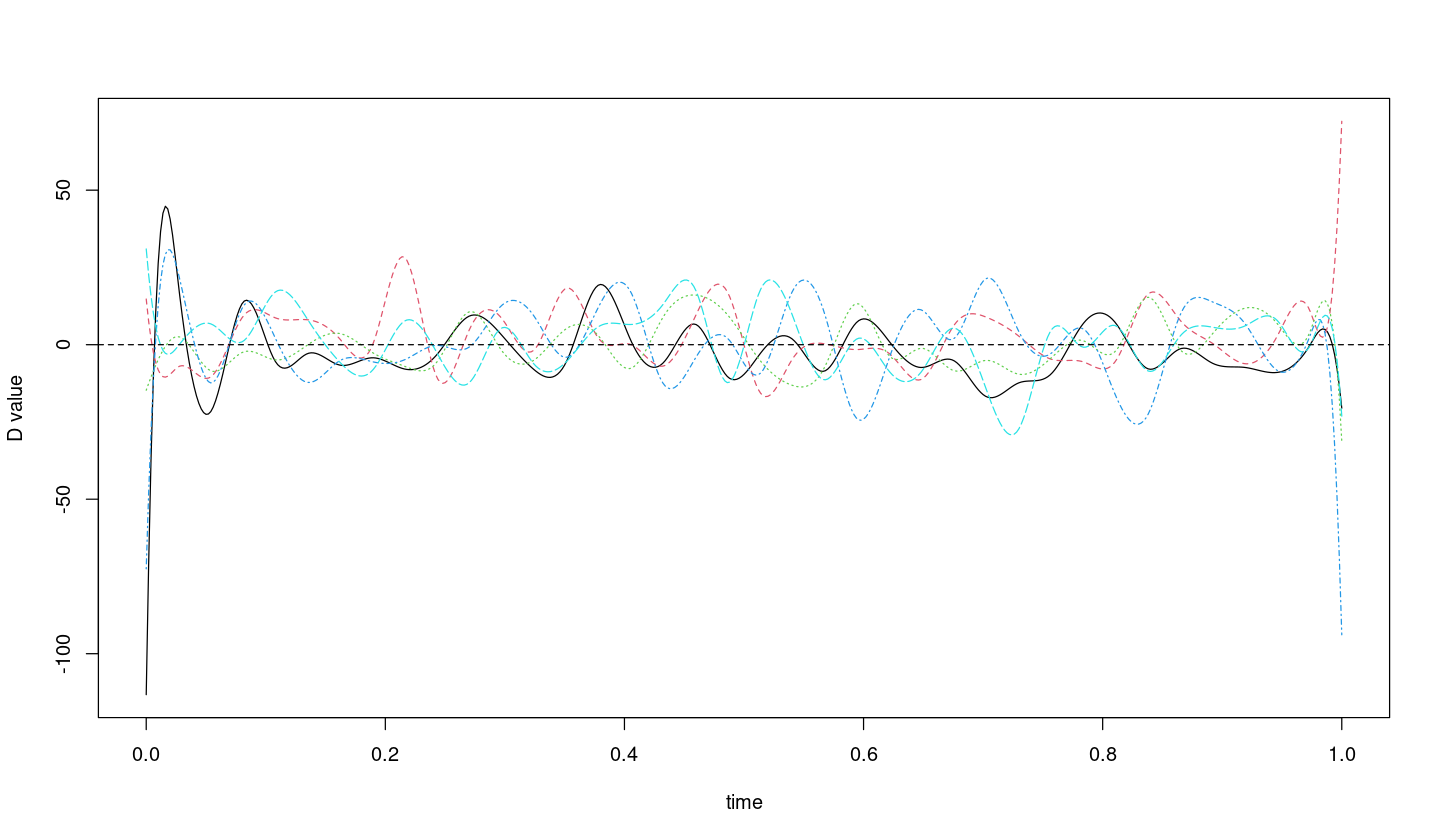

In [41]:
X.deriv <- deriv.fd(X.fd$fd, 1)
plot(X.deriv[1:5], xlim=LIMITES)

Y ploteamos una observacion (en negro) junto a su derivada primera (en azul) para confirmar la "correctitud" general

[1] "done"

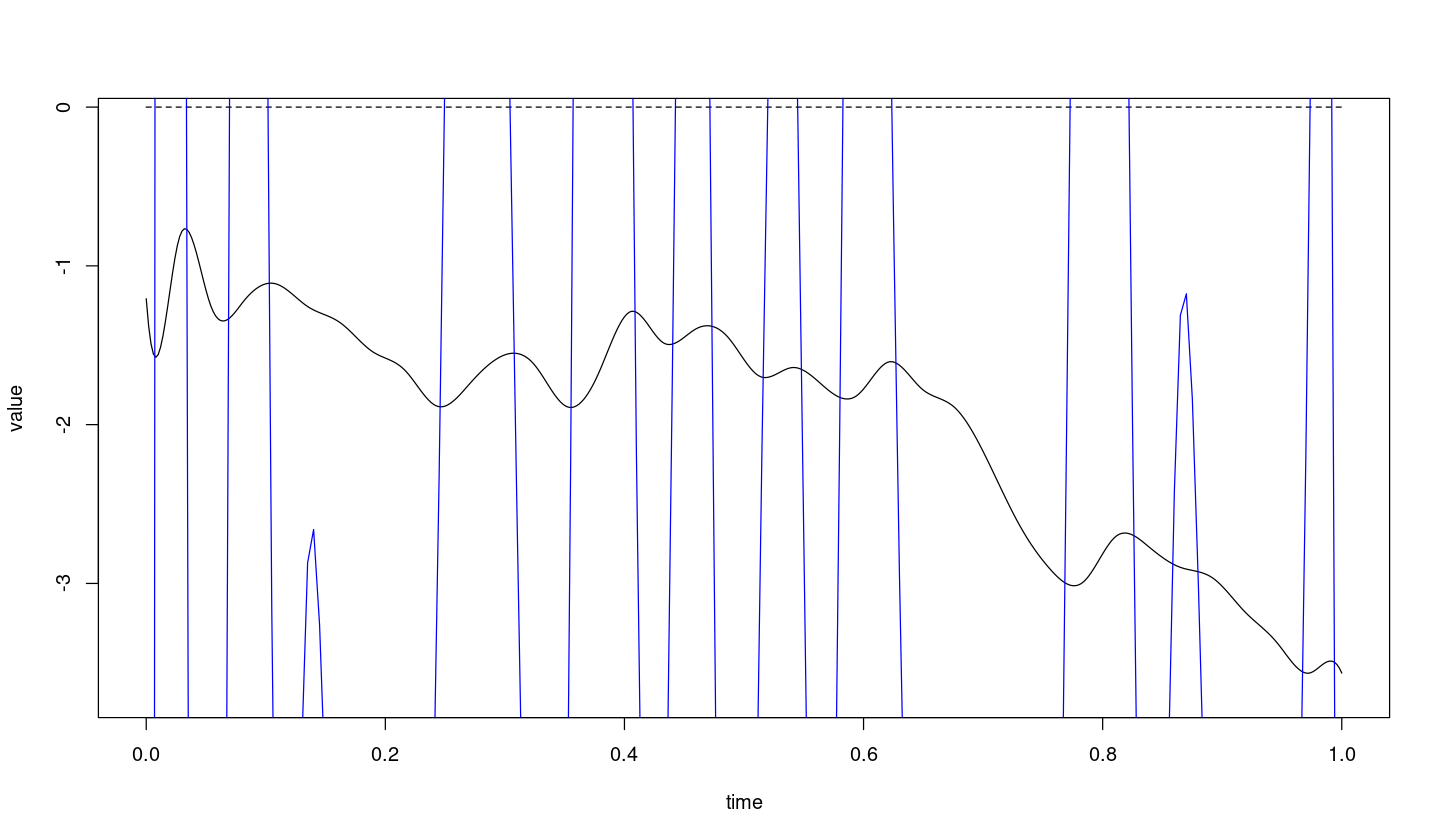

In [50]:
plot(X.fd$fd[1], ylim = range(X.fd$fd[1]$coefs))
lines(GRILLA, rep(0, T), lty=2)
lines(X.deriv[1], col="blue")

#### Calculadas "a mano" numericamente

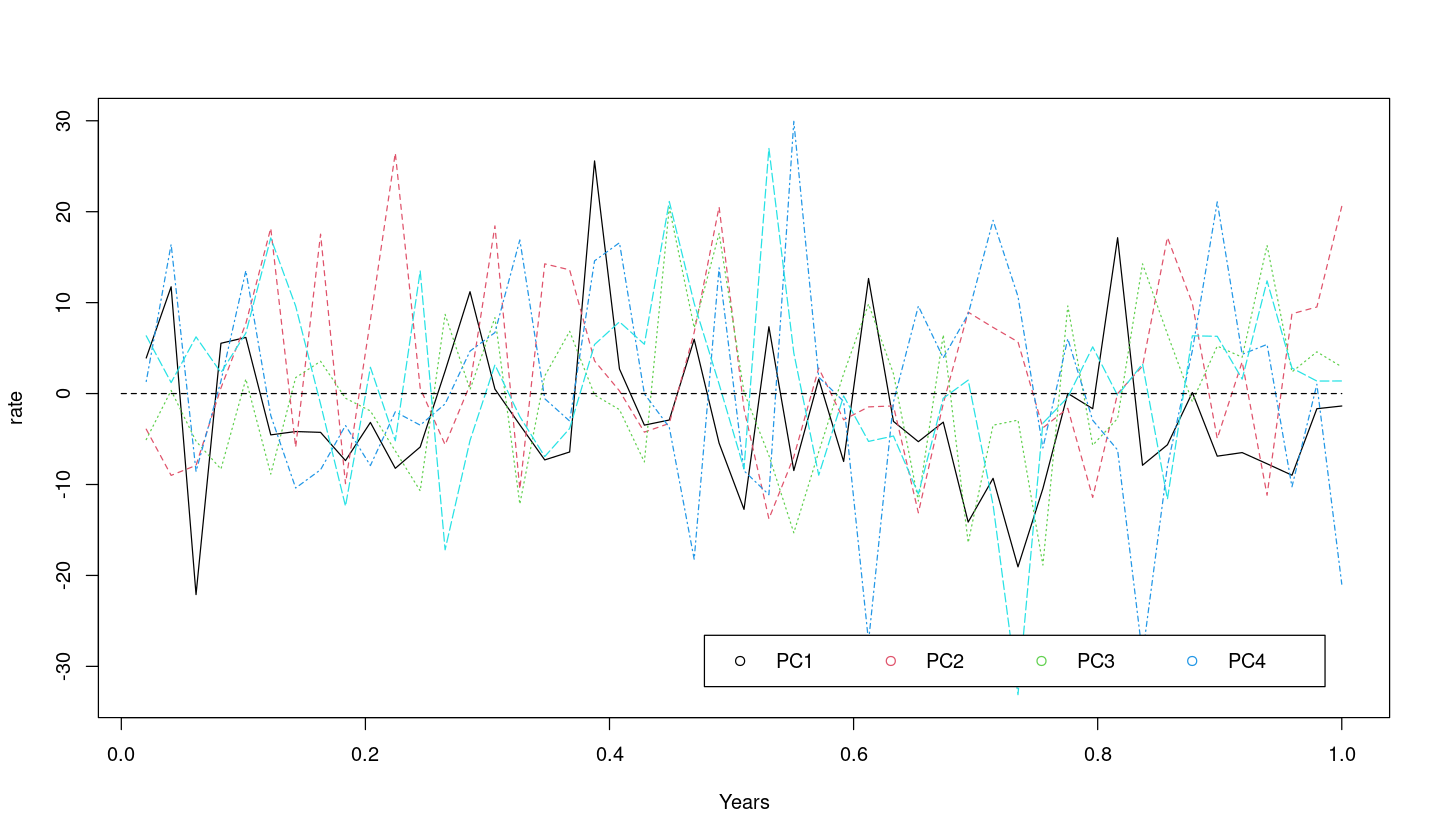

In [46]:
X.deriv_num <- (X[2:T,] - X[1:(T-1),]) / ((LIMITES[2] - LIMITES[1]) / (T - 1))
# X.deriv_num[,1]
# plot(GRILLA, X[,1] , 'l')
matplot(GRILLA[2:T], X.deriv_num[,1:5], type='l', xlab='Years', ylab='rate', col=1:5)
legend('bottomright', inset=.05, legend=c("PC1", "PC2", "PC3", "PC4"), 
                            pch=1, horiz=TRUE, col=1:5)# lines(GRILLA, X[,1] , 'l', xlim=LIMITES, col='blue')
lines(GRILLA, rep(0, T), lty=2)

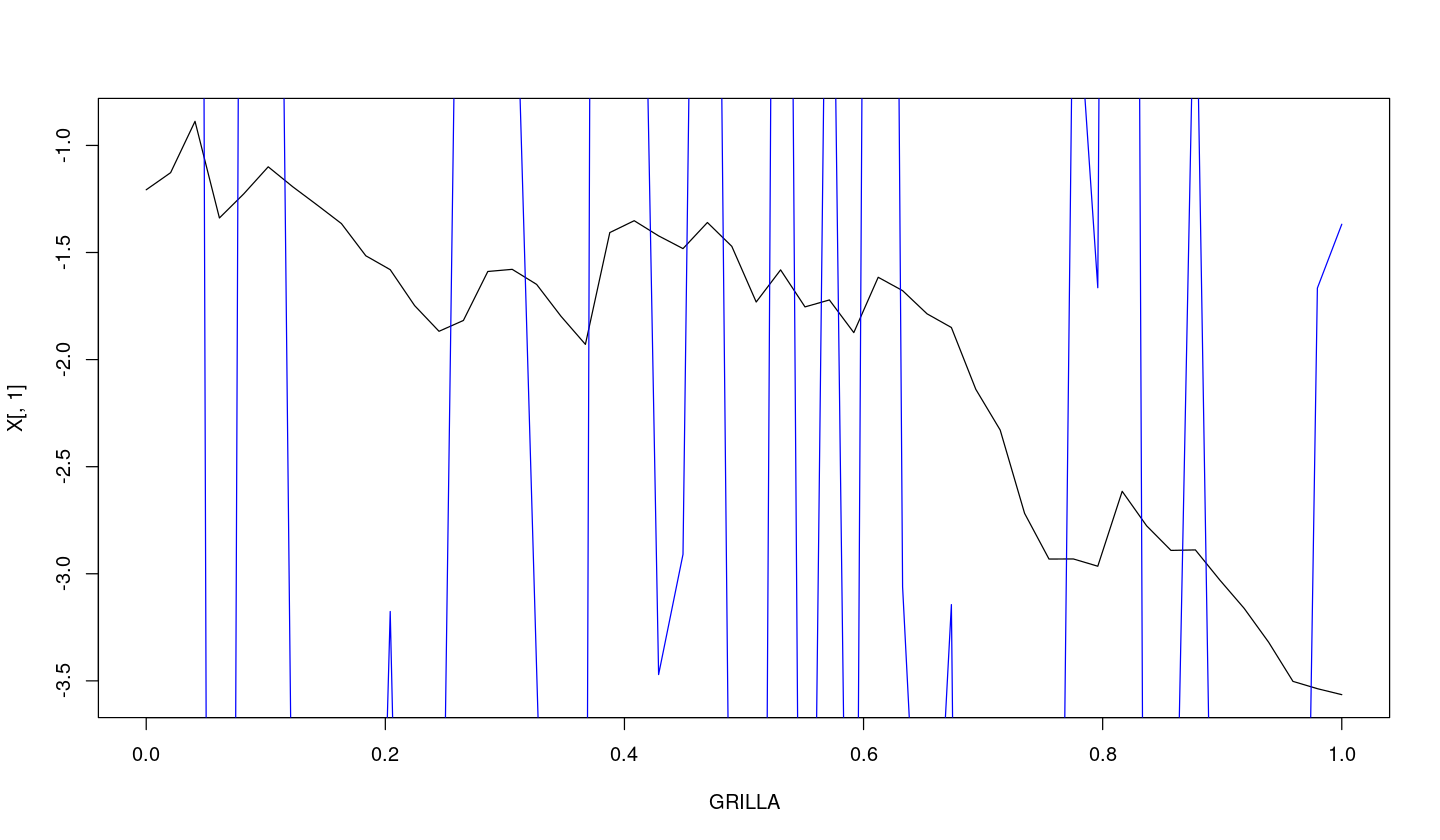

In [51]:
plot(GRILLA, X[,1] , 'l', ylim = range(X[,1]))
lines(GRILLA, rep(0, T), lty=2)
lines(GRILLA[2:T], X.deriv_num[,1], col="blue")

### RGL: Graficos 3D interactivos

Todo robado de este primer link:
- http://www.sthda.com/english/wiki/a-complete-guide-to-3d-visualization-device-system-in-r-r-software-and-data-visualization#rgl_init-a-custom-function-to-initialize-rgl-device
- https://rpubs.com/vaungles/481700

In [52]:
library(rgl)
source("scripts/rglutils.R")
# options(rgl.printRglwidget = TRUE)

Un ejemplo con `iris`

In [53]:
data(iris)
head(iris)

x <- sep.l <- iris$Sepal.Length
y <- pet.l <- iris$Petal.Length
z <- sep.w <- iris$Sepal.Width

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


In [54]:
rgl_init()
rgl.spheres(x, y, z, r = 0.2, 
          color = get_colors(iris$Species)) 
rgl_add_axes(x, y, z, show.bbox = FALSE)
# This writes a copy into temporary directory 'webGL',
# and then displays it
browseURL(
  paste("file://", writeWebGL(dir=file.path(tempdir(), "webGL"), 
  width=500), sep="")
  )

Loading required namespace: rmarkdown



In [55]:
rgl_init()
z <- resultados[[1]]$gammahat
nbcol = 100
color = rev(rainbow(nbcol, start = 0/6, end = 4/6))
zcol  = cut(z, nbcol)
persp3d(GRILLA, GRILLA, z, col=color[zcol])
DIR = "webGL"
writeWebGL(DIR, filename = file.path(DIR, "gammahat.html"), width = 960)

In [56]:
rgl_init()
z <- resultados[[1]]$matcov
nbcol = 100
color = rev(rainbow(nbcol, start = 0/6, end = 4/6))
zcol  = cut(z, nbcol)
persp3d(GRILLA, GRILLA, z, col=color[zcol])
DIR = "webGL"
writeWebGL(DIR, filename = file.path(DIR, "matcov.html"), width = 960)